## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Required Functions

In [1]:
import numpy as np
import collections
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# distortion correction
def distortion_correction(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# threshold binary
def filter_color(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
    yellow_min = np.array([15, 97, 97], np.uint8)
    yellow_max = np.array([30, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(img, yellow_min, yellow_max)

    white_min = np.array([0, 0, 97], np.uint8)
    white_max = np.array([30, 25, 255], np.uint8)
    white_mask = cv2.inRange(img, white_min, white_max)

    #img = cv2.bitwise_and(img, img, mask=yellow_mask)
    #img = cv2.bitwise_and(img, img, mask=white_mask)
    img = cv2.bitwise_and(img, img, mask=cv2.bitwise_or(yellow_mask, white_mask))
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

def region_of_interest(img):
    
    vertices = np.array([
        [img.shape[1] / 2, (img.shape[0] / 2)  + 50],
        [0, img.shape[0]],
        [img.shape[1], img.shape[0]]
    ], dtype=np.int32)
    
    mask = np.zeros_like(img)   
    
    ignore_mask_color = 1
    
    cv2.fillConvexPoly(mask, vertices, ignore_mask_color)
    
    return cv2.bitwise_and(img, mask)

def abs_thresh(img, thresh):
    img = np.absolute(img)
    img = np.uint8(255 * img / np.max(img))
    binary_output = np.zeros_like(img)
    binary_output[img >= thresh] = 1
    return binary_output

def mag_thresh(img_x, img_y, thresh):    
    img = np.sqrt(img_x**2 + img_y**2)
    img = np.uint8(255 * img / np.max(img))
    
    binary_output = np.zeros_like(img)
    binary_output[img >= thresh] = 1
    return binary_output

def dir_thresh(img_x, img_y, thresh):        
    img_x = np.absolute(img_x)
    img_y = np.absolute(img_y)
    
    img = np.arctan2(img_y, img_x)
        
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

def canny_thresh(img, thresh):
    img = cv2.Canny(img,62,124)
    binary_output = np.zeros_like(img)
    binary_output[img >= thresh] = 1
    return binary_output

def get_threshold_binary(img):    
    ksize = 11
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img = img[:,:,2]
    
    # Get Sobel in x and y
    img_x = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=ksize)
    img_y = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=ksize)

    gradx = abs_thresh(img_x, thresh=6)
    grady = abs_thresh(img_y, thresh=6)
    
    magnitude = mag_thresh(img_x, img_y, thresh=6)
    direction = dir_thresh(img_x, img_y, thresh=(0.6, 1.4))
    
    canny = canny_thresh(img, thresh=6)
    
    # Thresholded image
    img = np.zeros_like(img)
    img[((gradx == 1) & (grady == 1) & (magnitude == 1) & (direction == 1)) | (canny == 1)] = 1
    
    return region_of_interest(img)

# Perspective Transformation
def perspective_transform(img, overlayed=None):
    src = np.array([[592, 450],[689, 450],[1071, 700],[209, 700]])
    dst = np.array([[320, 50],[960, 50],[960, 700],[320, 700]])
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    
    if type(overlayed) is np.ndarray:
        overlayed[:,:,0] = img
        overlayed[:,:,1] = img
        overlayed[:,:,2] = img
        cv2.polylines(overlayed, [src.reshape((-1,1,2))],True,(0,1,1),2)

    w = img.shape[1]
    h = img.shape[0]
    result = cv2.warpPerspective(img, M, (w, h))
    
    #result = np.concatenate([
    #    perspective_transform_pass2(result[:,:int(w/2)]), 
    #    perspective_transform_pass2(result[:,int(w/2):])
    #], axis=1)
        
    return result, M

def perspective_transform_pass2(img):
    adjustment = 80
    
    src = np.array([[160, 50],[480, 50],[480, 700],[160, 700]])
    dst = np.array([[160+adjustment, 50],[480-adjustment, 50],[480+adjustment, 700],[160-adjustment, 700]])
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))

    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))


# left-right peak detection
def argmax(a):
    max_start = np.argmax(a)
    max_end = len(a) - np.argmax(a[::-1])
    return int((max_start + max_end) / 2)

def peak_detection(img):
    img_shape = img.shape

    middle = int(img_shape[1] / 2)

    half_img = img[int(img_shape[0] / 2):, :]
    histogram = np.sum(half_img, axis=0)
    
    # find the left and right starting points
    lb = argmax(histogram[:middle])
    rb = argmax(histogram[middle:]) + middle

    return lb, rb

def normalize_samples(l_samples, r_samples):
    widths = r_samples[:,0] - l_samples[:,0]

    # lane width should not be less than 600
    mean_width = np.max([np.mean(widths), 600])
    
    diff = (widths - mean_width) / 2
    l_samples[:,0] = l_samples[:,0] + diff
    r_samples[:,0] = r_samples[:,0] - diff
    return l_samples, r_samples

# curve detection
def curvature_detection(img, old_l_samples=[], old_r_samples=[], img_c=None):
    threshold = 100
    
    stride_height = 50
    window_height = 100
    window_width = 50

    img_shape = img.shape

    img_height = img_shape[0]
    img_width = img_shape[1]

    if (len(old_l_samples) == 0) | (len(old_r_samples) == 0):
        old_samples_provided = False
        print("detecting left and peak from current image")
        lp, rp = peak_detection(img)
        lane_widths = [rp - lp] * int((img_height / stride_height) + 1)
    else:
        old_samples_provided = True
        lp = old_l_samples[0, 0]
        rp = old_r_samples[0, 0]
        lane_widths = old_r_samples[:, 0] - old_l_samples[:, 0]
        
    # result
    l_samples = []
    r_samples = []

    # window sliding
    i = 0
    for window_y_end in range(img_height, stride_height, -stride_height):
        window_y_start = window_y_end - window_height
        
        # histogram for entire horizon of current window slide
        histogram = np.sum(img[window_y_start:window_y_end, int(window_width / 2) : -int(window_width / 2)], axis=0)

        # calculate convolution by sliding window accross the horizon
        window = np.ones(window_width)
        conv = np.convolve(window, histogram)
                
        # left window based on previous left peak
        window_l_start = int(lp - (window_width / 2))
        window_l_end = window_l_start + window_width

        # right window based on previous right peak
        window_r_start = int(rp - (window_width / 2))
        window_r_end = window_r_start + window_width

        # new left and right peaks
        l_found = sum(conv[window_l_start:window_l_end]) > threshold
        r_found = sum(conv[window_r_start:window_r_end]) > threshold

        if r_found & l_found:
            lp = argmax(conv[window_l_start:window_l_end]) + window_l_start
            rp = argmax(conv[window_r_start:window_r_end]) + window_r_start 
        else:
            if l_found:
                lp = argmax(conv[window_l_start:window_l_end]) + window_l_start
                rp = min(lp + lane_widths[i], img_width)    
            if r_found:
                rp = argmax(conv[window_r_start:window_r_end]) + window_r_start 
                lp = max(rp - lane_widths[i], 0)

        # draw left window on output image (green if found, red otherwise)
        if type(img_c) is np.ndarray:
            l_window_color = [0,255,0] if l_found else [255, 0, 0]
            cv2.rectangle(img_c, (window_l_start, window_y_start), (window_l_end, window_y_end), l_window_color, 2)
            r_window_color = [0,255,0] if l_found else [255, 0, 0]
            cv2.rectangle(img_c, (window_r_start, window_y_start), (window_r_end, window_y_end), r_window_color, 2)

        l_samples.append([lp, window_y_end])
        r_samples.append([rp, window_y_end])
        
        window_width = window_width + 10
        i = i + 1
        
    l_samples = np.array(l_samples)
    r_samples = np.array(r_samples)
    #normalize_samples(l_samples, r_samples)
    
    if old_samples_provided:
        all_l_samples = np.concatenate((l_samples, old_l_samples))
        all_r_samples = np.concatenate((r_samples, old_r_samples))
    else:
        all_l_samples = l_samples
        all_r_samples = r_samples
        
    l_fit = np.polyfit(all_l_samples[:,1], all_l_samples[:,0], 2)
    r_fit = np.polyfit(all_r_samples[:,1], all_r_samples[:,0], 2)
    
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 30/720 # meters per pixel in y dimension

    # Fit new polynomials to x,y in world space
    l_fit_r = np.polyfit(all_l_samples[:,1]*ym_per_pix, all_l_samples[:,0]*xm_per_pix, 2)
    r_fit_r = np.polyfit(all_r_samples[:,1]*ym_per_pix, all_r_samples[:,0]*xm_per_pix, 2)
    
    return l_samples, r_samples, l_fit, r_fit, l_fit_r, r_fit_r

def add_curvature_overlay(img, l_fit, r_fit, l_fit_r, r_fit_r, M):
    img_shape = img.shape

    img_height = img_shape[0]
    img_width = img_shape[1]
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    y_plot = np.linspace(0, img_height-1, img_height)
    l_plot = l_fit[0] * y_plot ** 2 + l_fit[1] * y_plot + l_fit[2]
    r_plot = r_fit[0] * y_plot ** 2 + r_fit[1] * y_plot + r_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([l_plot, y_plot]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_plot, y_plot])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (img_width, img_height), flags=cv2.WARP_INVERSE_MAP) 
    
    # Calculate the new radii of curvature
        
    y_eval = np.max(y_plot)
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    l_c = ((1 + (2*l_fit_r[0]*y_eval*ym_per_pix + l_fit_r[1])**2)**1.5) / np.absolute(2*l_fit_r[0])
    r_c = ((1 + (2*r_fit_r[0]*y_eval*ym_per_pix + r_fit_r[1])**2)**1.5) / np.absolute(2*r_fit_r[0])    

    cv2.putText(img, 'L={:.4f}y^2{:+.4f}y{:+.4f}'.format(l_fit[0], l_fit[1], l_fit[2]), (10,220),
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

    cv2.putText(img, 'R={:.4f}y^2{:+.4f}y{:+.4f}'.format(r_fit[0], r_fit[1], r_fit[2]), (10,260),
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    cv2.putText(img, 'Left: {:.2f}m, Right: {:.2f}m'.format(l_c, r_c), (10,300),
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

    cv2.putText(img, 'Offset: {:+.2f}m'.format(((r_plot[-1] + l_plot[-1]) / 2 - (img_width / 2)) * xm_per_pix), (10,340),
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


def process_image(image, mtx, dist):    
    global l_sample_history, r_sample_history
    
    img = distortion_correction(image, mtx, dist)
    
    #img = filter_color(img)
    
    img = get_threshold_binary(img)
    
    img, M = perspective_transform(img) 

    img_c = np.dstack([img, img, img]) * 255
    
    l_sh = np.array(l_sample_history).reshape(-1, 2)
    r_sh = np.array(r_sample_history).reshape(-1, 2)
    
    new_l_samples, new_r_samples, l_fit, r_fit, l_fit_c, r_fit_c = curvature_detection(img, l_sh, r_sh, img_c)
    
    l_sample_history.append([new_l_samples])
    r_sample_history.append([new_r_samples])
    
    img_c = cv2.resize(img_c, (int(img_c.shape[1] / 4), int(img_c.shape[0] / 4))) 
    
    result = add_curvature_overlay(image, l_fit, r_fit, l_fit_c, r_fit_c, M)
        
    result[10:img_c.shape[0] + 10, 10:img_c.shape[1] + 10] = img_c
    
    return result

## Camera Calibration

corners not found in  camera_cal\calibration1.jpg
corners not found in  camera_cal\calibration4.jpg
corners not found in  camera_cal\calibration5.jpg


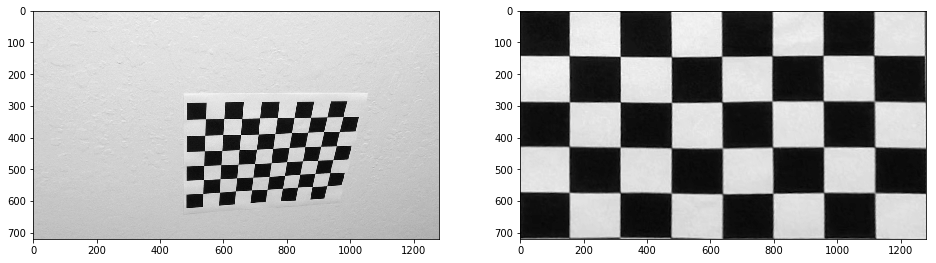

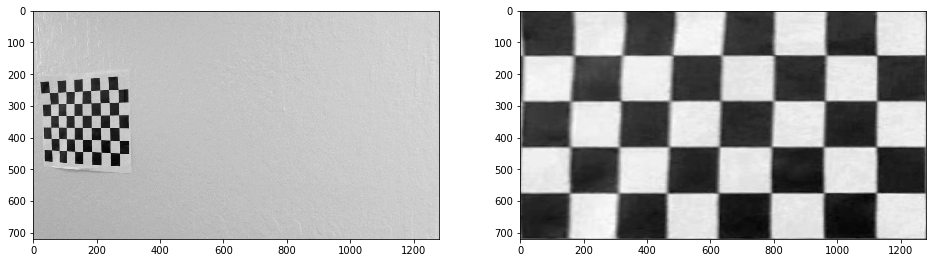

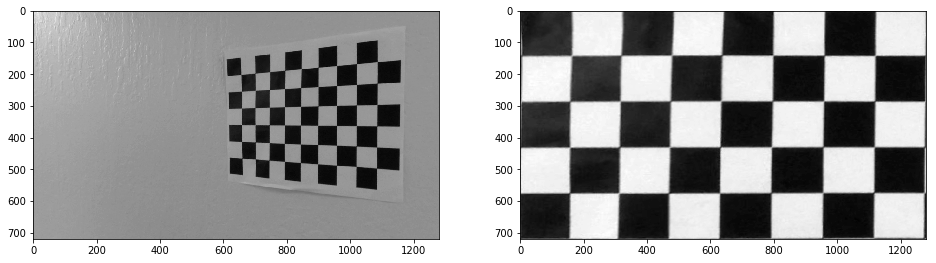

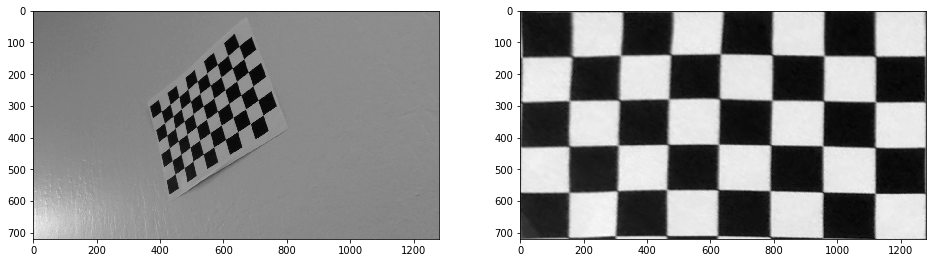

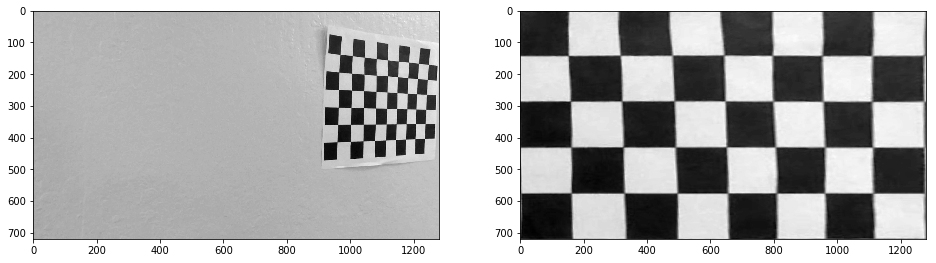

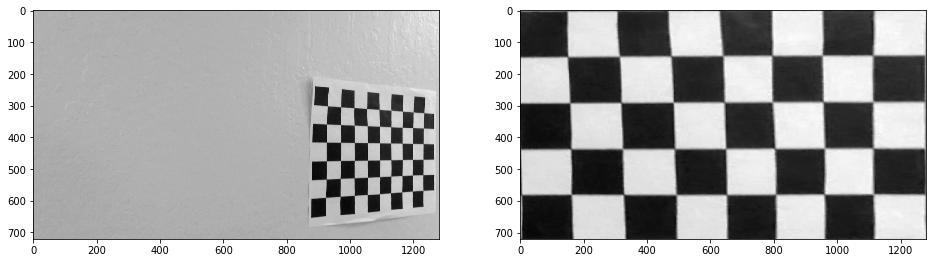

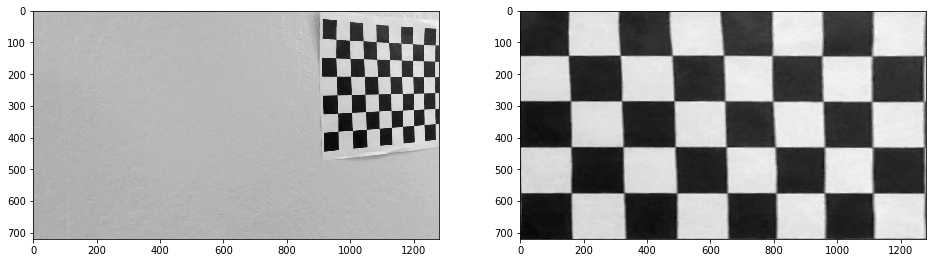

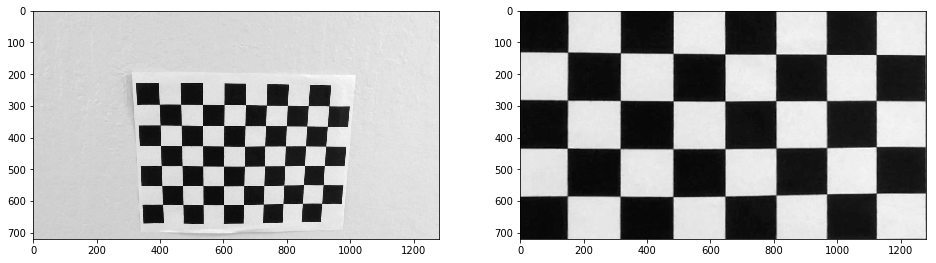

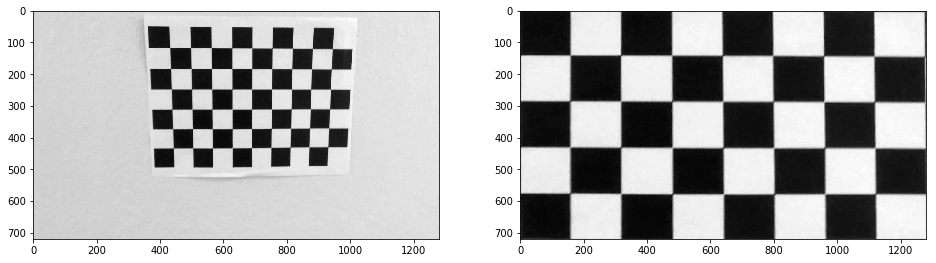

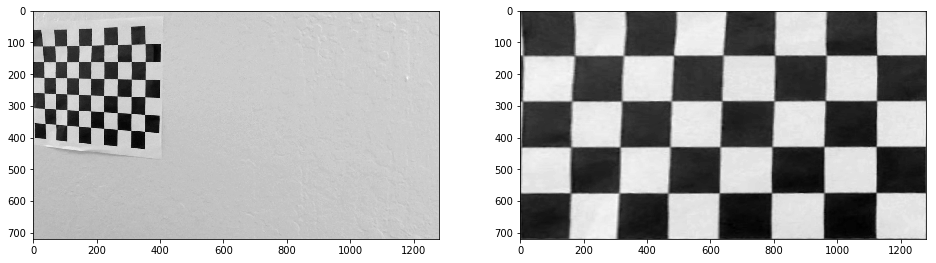

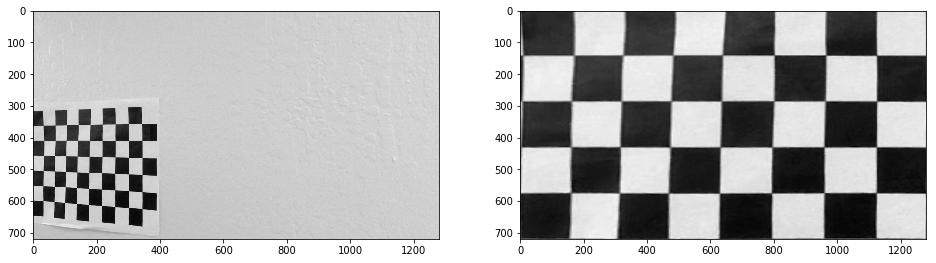

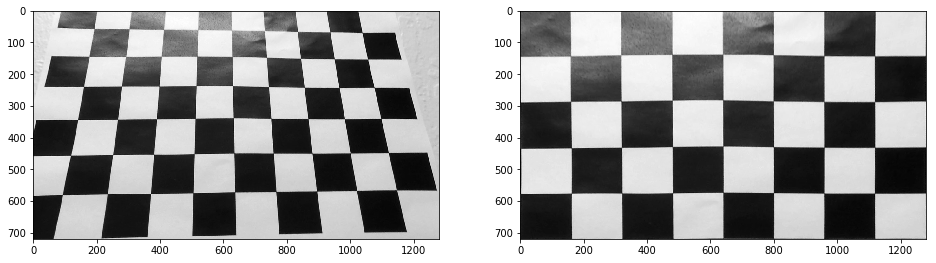

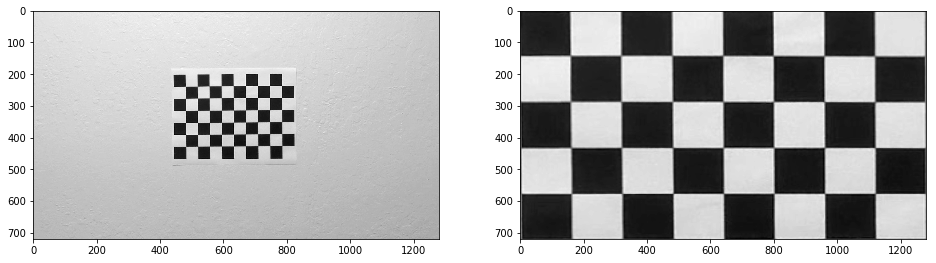

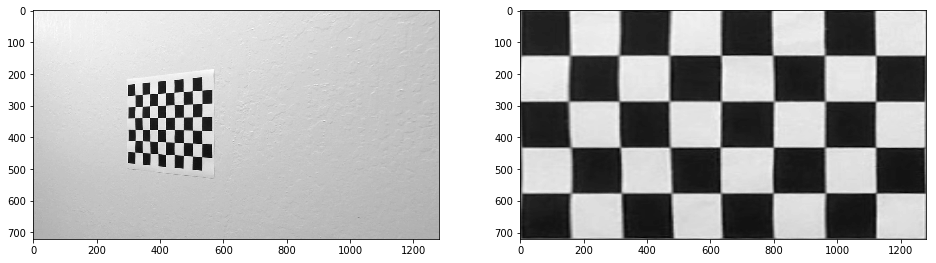

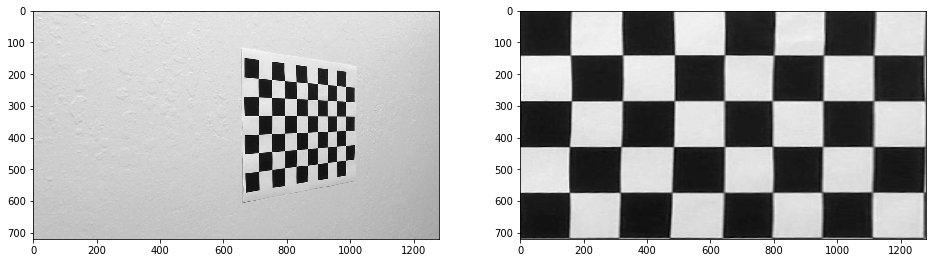

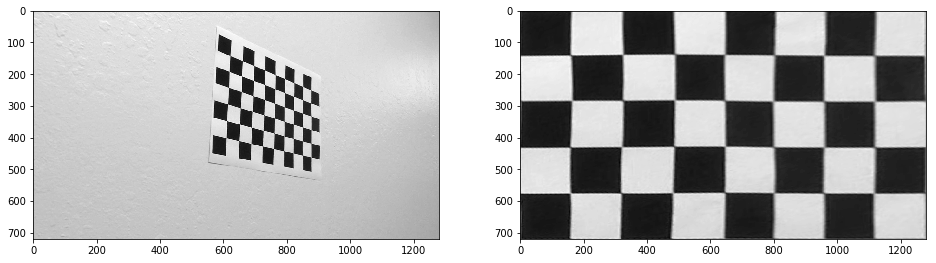

In [2]:
figure_size = (16, 16)

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
gray_images = []

for fname in images:
    img = cv2.imread(fname)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    found, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if found:
        objpoints.append(objp)
        imgpoints.append(corners)
        gray_images.append(gray)
    else:
        print("corners not found in ", fname)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

shape = (gray_images[0].shape[1], gray_images[0].shape[0])
upper_left = [0, 0]
upper_right = [shape[0], 0]
lower_right = [shape[0], shape[1]]
lower_left = [0, shape[1]]
dst = np.float32([upper_left, upper_right, lower_right, lower_left])
        
for img in gray_images:

    f = plt.figure(figsize=figure_size)
        
    img = cv2.undistort(img, mtx, dist)
    
    found, corners = cv2.findChessboardCorners(img, (nx, ny))
    
    if found:
        f.add_subplot(1,2,1)
        plt.imshow(img, cmap='gray')
    
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

        M = cv2.getPerspectiveTransform(src, dst)

        img = cv2.warpPerspective(img, M, shape)

        f.add_subplot(1,2,2)
        plt.imshow(img, cmap='gray')

## Image Testing

### 1. Distortion Correction

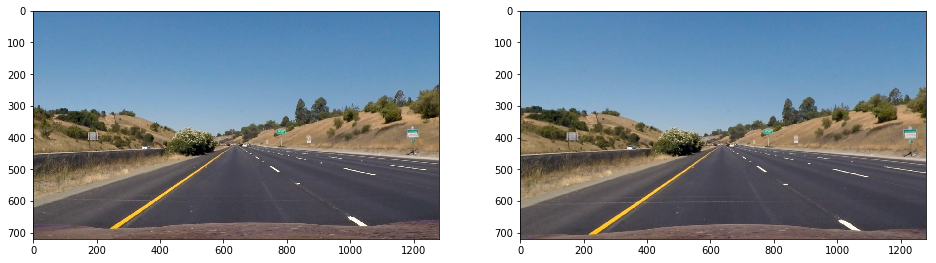

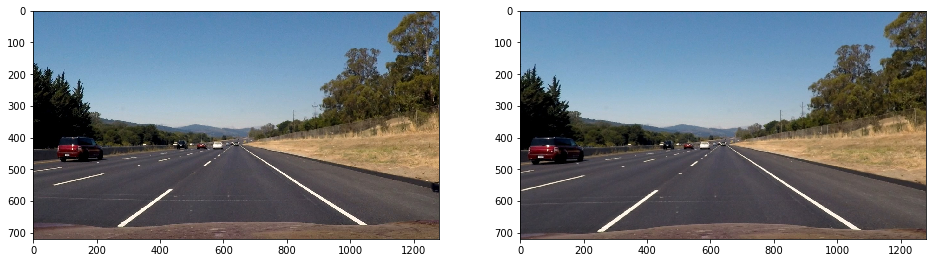

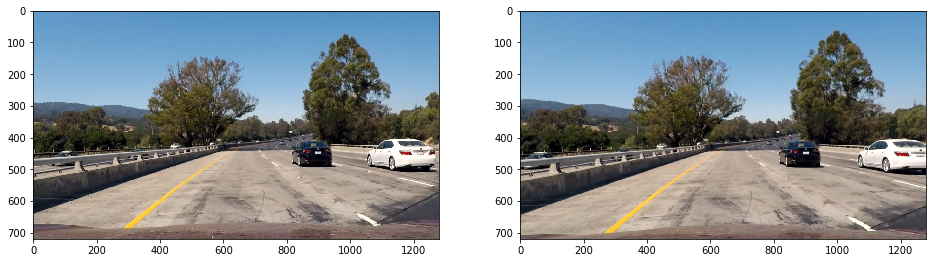

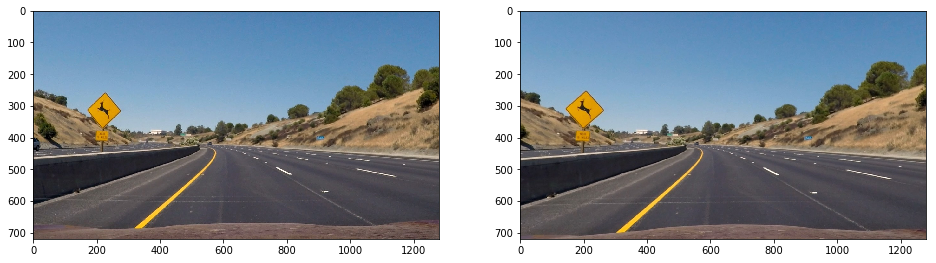

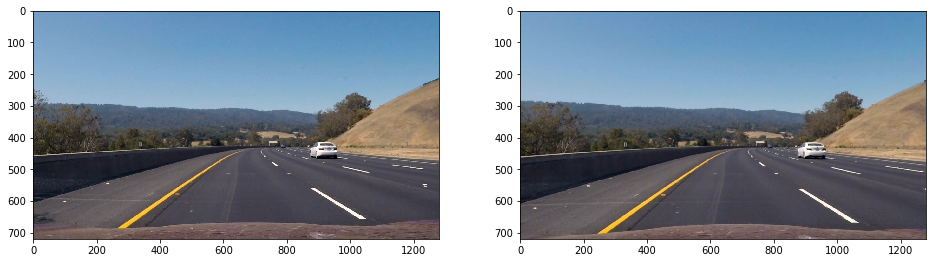

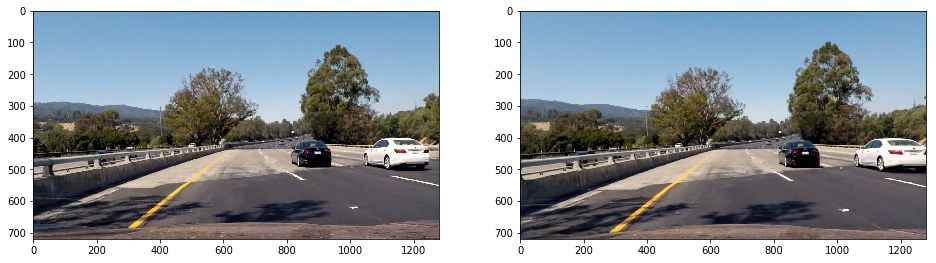

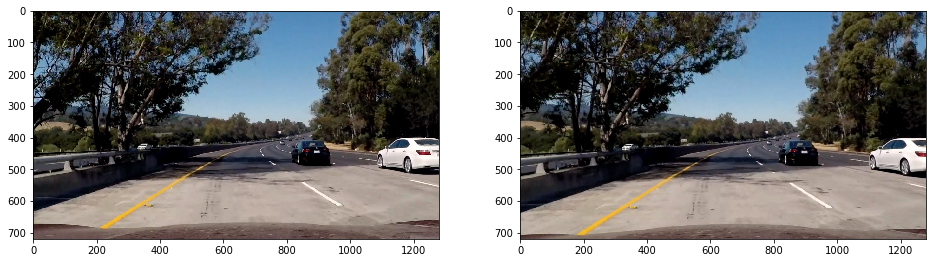

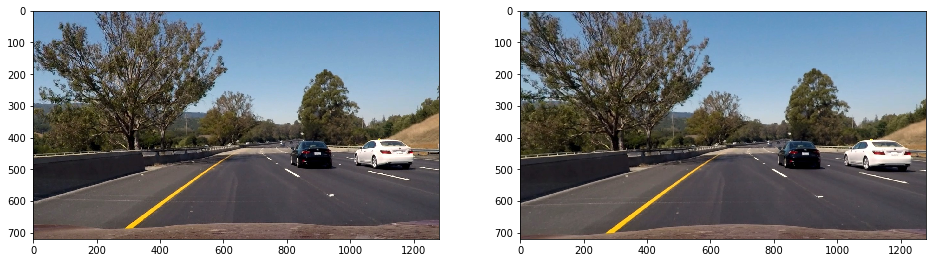

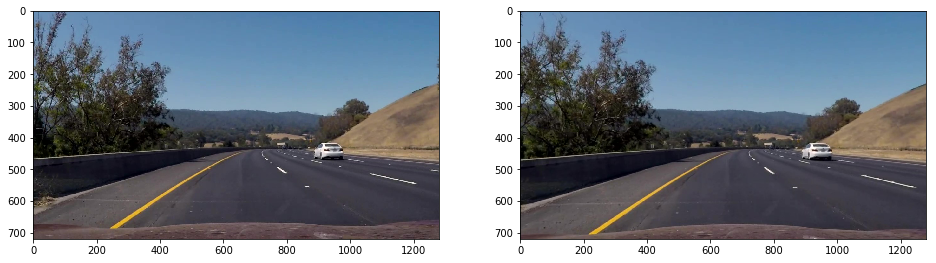

In [3]:
images = glob.glob('test_images/*.jpg')

original_images = []
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_images.append(img)

corrected_images = []
for img in original_images:
    f = plt.figure(figsize=figure_size)        
    f.add_subplot(1,2,1)
    plt.imshow(img)
    
    img = distortion_correction(img, mtx, dist)

    f.add_subplot(1,2,2)
    plt.imshow(img)
    
    corrected_images.append(img)

### 2. Threshold Binary

In [ ]:
binary_images = []

for img in corrected_images:

    #img = filter_color(img)
    
    # Original image
    f = plt.figure(figsize=figure_size)
    f.add_subplot(1,2,1)
    
    # Get the channel
        
    img_v = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_v = img[:,:,2]

    plt.imshow(img_v, cmap='gray')
    
    img = get_threshold_binary(img)
    
    f.add_subplot(1,2,2)
    plt.imshow(img, cmap='gray')
    
    binary_images.append(img)


### 3. Perspective Transform

In [ ]:
warped_images = []

for img in binary_images:

    f = plt.figure(figsize=figure_size)

    overlayed = np.ndarray(shape=img.shape + (3,))

    warped, M = perspective_transform(img, overlayed) 
    
    f.add_subplot(1,2,1)
    plt.imshow(overlayed)
    
    f.add_subplot(1,2,2)
    plt.imshow(warped, cmap='gray')
    
    warped_images.append(warped)
    

### 4. Left/Right Peak Detection

In [ ]:
left_right_peaks = []

for img in warped_images:
    half_img = img[int(img.shape[0] / 2):, :]
    
    f = plt.figure(figsize=figure_size)

    # draw source image on the left
    ax = f.add_subplot(1,2,1)
    plt.imshow(half_img, cmap='gray')
    
    # draw the histogram on the right
    ax = f.add_subplot(1,2,2)
    ax.set_aspect(1)
    plt.plot(np.sum(half_img, axis=0))
    
    lb, rb = peak_detection(img)
    
    left_right_peaks.append([lb, rb])
    
    # draw the left and right marks on histogram
    middle = int(img.shape[1] / 2)
    plt.plot(np.ones(middle) + lb, np.arange(middle) / 1.8)
    plt.plot(np.ones(middle) + rb, np.arange(middle) / 1.8)
    
    

### 5. Curvature Detection

In [ ]:
for i in range(len(warped_images)):
    # each image
    img = warped_images[i]

    # starting left and right peaks    
    lp, rp = left_right_peaks[i]

    # for fancy stuff
    img_c = np.dstack([img, img, img]) * 255
    
    # figure
    f = plt.figure(figsize=figure_size)

    l_samples, r_samples, l_fit, r_fit, l_fit_c, r_fit_c = curvature_detection(img, [], [], img_c)
    
    ax = f.add_subplot(1,2,1)
    plt.imshow(img_c)

    l_fit = np.polyfit(l_samples[:,1], l_samples[:,0], 2)
    r_fit = np.polyfit(r_samples[:,1], r_samples[:,0], 2)
    
    y_plot = np.linspace(0, img.shape[0]-1, img.shape[1])
    l_plot = l_fit[0] * y_plot ** 2 + l_fit[1] * y_plot + l_fit[2]
    r_plot = r_fit[0] * y_plot ** 2 + r_fit[1] * y_plot + r_fit[2]
    
    plt.plot(l_plot, y_plot, color='yellow')
    plt.plot(r_plot, y_plot, color='yellow')
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    
    result = add_curvature_overlay(original_images[i], l_fit, r_fit, l_fit_c, r_fit_c, M)
    ax = f.add_subplot(1,2,2)
    plt.imshow(result)

## Video Testing

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

num_history = 5

# set global
l_sample_history = collections.deque([], num_history)
r_sample_history = collections.deque([], num_history)

output_video_path = 'project_video_output.mp4'
output_video = VideoFileClip("project_video.mp4").fl_image(lambda img: process_image(img, mtx, dist))

# reset global
l_sample_history = collections.deque([], num_history)
r_sample_history = collections.deque([], num_history)

%time output_video.write_videofile(output_video_path, audio=False, threads=4)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))